**This file contains the code to:**
1. **Data Preprocessing:** Cropping the data and then later converting it into grayscale.
2. **Visualization:** Rendering the data using ```matplotlib```.
3. **Data Storage:** Saving the preprocessed data as a series of ```.png``` slices to AWS S3 Buckets.

**Installing the required Libraries:**

In [ ]:
%pip install boto3 nibabel numpy matplotlib scikit-image opencv-python

**Importing those Libraries:**

In [1]:
import boto3
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import io
import tempfile
import os

**In this Cell, we will render ```.nii``` files  from the S3 Bucket and save each file as a collection of 2d ```.png``` slices in a folder in the same S3 Bucket.**
1. **Connect to S3:** we will connect to our S3 bucket using the ```boto3``` library.
2. **Define Cropping Parameters:** we define our  ```crop``` values to crop out irrelevant data from the slices.
3. **Define Key Functions:** we implement functions to handle rendering and saving the data.

**The Rendering Function:** ```render_nii_from_s3()```

The function displays the middle 2d brain slice from a 3d ```.nii``` file. 

1. The function takes a ```.nii``` ```filename``` and locates it in the S3 Bucket.
2. Downloads the ```.nii``` file using a ```tempfile```.
3. Reads the ```data``` from the ```tempfile``` (converting it into a vector).
3. Finds the middle index (```slice_idx```) of the ```data``` vector.
4. Applies the defined ```crop``` to the ```data``` to obtain the ```start_x```, ```start_y```, ```end_x```, and ```end_y``` values.
5. Generates ```slice_2d``` using the middle index, the start and end values, and index slicing.
6. Visualizes ```slice_2d``` in grayscale using ```matplotlib.pyplot``` and displays it with the appropriate title.
7. Deletes the ```tempfile``` after the visualization is complete.
8. The function includes robust error handling for scenarios such as corrupted or empty ```.nii``` files or errors during loading or visualization.

**The Saving Function:** ```save_png_from_nii()```

The function converts a 3d ```.nii``` file into a series of ```.png``` slices and uploads them to the S3 Bucket.

1. The function takes a ```.nii``` ```filename``` and locates it in the S3 Bucket.
2. Downloads the ```.nii``` file using a ```tempfile```.
3. Reads the ```data``` from the downloaded file (converting it into a vector).
4. Iterates over each ```slice_2d``` in the brain and does the following:

    - Applies the defined ```crop``` to the slice, generating a ```slice_2d```.
    - Extracts ```brain_number``` and ```scan_type``` from the ```filename``` using delimiters.
    - Constructs the ```slice_path``` based on ```brain_number``` and ```scan_type``` for saving the ```slice_2d``` in the S3 Bucket.
    - Names the ```.png``` file using ```slice_idx``` (slice index) and the ```slice_path```.
    - Saves the ```slice_2d``` as a grayscale ```.png``` file using a ```tempfile``` and uploads it to the S3 Bucket in the ```tanmay/``` directory.
    - Deletes the ```tempfile``` after the upload is complete.
    
5. The function includes robust error handling for scenarios such as corrupted or empty ```.nii``` files or failures during file processing or uploading.

Fetching file: BraTS20_Training_002/BraTS20_Training_002_flair.nii


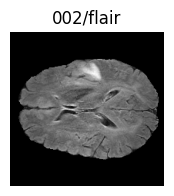

Fetching file: BraTS20_Training_002/BraTS20_Training_002_flair.nii
Saving files in directory: brain_slices/002/flair
Fetching file: BraTS20_Training_002/BraTS20_Training_002_seg.nii


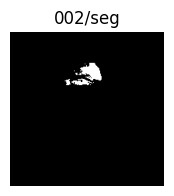

Fetching file: BraTS20_Training_002/BraTS20_Training_002_seg.nii
Saving files in directory: brain_slices/002/seg
Fetching file: BraTS20_Training_002/BraTS20_Training_002_t1.nii


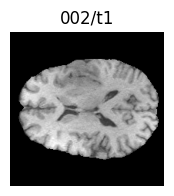

Fetching file: BraTS20_Training_002/BraTS20_Training_002_t1.nii
Saving files in directory: brain_slices/002/t1
Fetching file: BraTS20_Training_002/BraTS20_Training_002_t1ce.nii


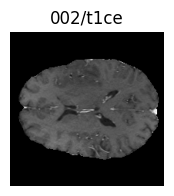

Fetching file: BraTS20_Training_002/BraTS20_Training_002_t1ce.nii
Saving files in directory: brain_slices/002/t1ce
Fetching file: BraTS20_Training_002/BraTS20_Training_002_t2.nii


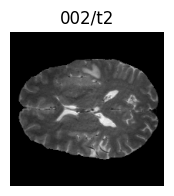

Fetching file: BraTS20_Training_002/BraTS20_Training_002_t2.nii
Saving files in directory: brain_slices/002/t2
Fetching file: BraTS20_Training_003/BraTS20_Training_003_flair.nii
Saving files in directory: brain_slices/003/flair
Fetching file: BraTS20_Training_003/BraTS20_Training_003_seg.nii
Saving files in directory: brain_slices/003/seg
Fetching file: BraTS20_Training_003/BraTS20_Training_003_t1.nii
Saving files in directory: brain_slices/003/t1
Fetching file: BraTS20_Training_003/BraTS20_Training_003_t1ce.nii
Saving files in directory: brain_slices/003/t1ce
Fetching file: BraTS20_Training_003/BraTS20_Training_003_t2.nii
Saving files in directory: brain_slices/003/t2
Fetching file: BraTS20_Training_004/BraTS20_Training_004_flair.nii
Saving files in directory: brain_slices/004/flair
Fetching file: BraTS20_Training_004/BraTS20_Training_004_seg.nii
Saving files in directory: brain_slices/004/seg
Fetching file: BraTS20_Training_004/BraTS20_Training_004_t1.nii
Saving files in directory: b

In [ ]:
# setting up the data pipeline to access the brains in the AWS S3 Bucket folder path:

s3 = boto3.resource('s3')
bucket_name = 'chemocraft-data'
folder_path = 'MICCAI_BraTS2020_TrainingData/'
bucket = s3.Bucket(bucket_name)

crop = 20

def render_nii_from_s3(filename): 
    print(f"Fetching file: {filename}")

    obj = bucket.Object(folder_path + filename)
    file_stream = io.BytesIO(obj.get()['Body'].read())

    with tempfile.NamedTemporaryFile(suffix='.nii', delete=False) as temp_file: # disabling autodelete of the tempfile so it can be saved
        temp_file.write(file_stream.getvalue())
        temp_file.flush()

        temp_file_path = temp_file.name

    try:
        img = nib.load(temp_file_path)
        data = img.get_fdata() # storing the brain into the data variable

        if data.size == 0: # checking if data is nonexistent
            print(f"No data found in {filename}")
            return

        slice_idx = data.shape[2] // 2 # getting the index of the middle slice
        
        start_y = crop
        end_y = data.shape[0] - crop
        start_x = crop
        end_x = data.shape[1] - crop

        slice_2d = data[start_y:end_y, start_x:end_x, slice_idx]

        plt.figure(figsize=(2, 2)) # displaying the slice in a 2x2 cell
        plt.imshow(slice_2d, cmap='gray') # color set to grayscale

        filename = filename.removesuffix(".nii") 
        brain_number = filename.split('_')[-2]
        scan_type = filename.split('_')[-1]

        plt.title(f"{brain_number}/{scan_type}") # creating a title for the image
        plt.axis('off')  # hiding the axes for a cleaner display
        plt.show() # visualizing the middle slice

    except Exception as e:
        print(f"Error loading file {filename}: {e}") # error handling
    finally:
        try:
            os.remove(temp_file_path) 
        except OSError as cleanup_error:
            print(f"Error deleting temp file: {cleanup_error}")

def save_png_from_nii(filename):
    print(f"Fetching file: {filename}")
    obj = bucket.Object(folder_path + filename)
    file_stream = io.BytesIO(obj.get()['Body'].read())

    with tempfile.NamedTemporaryFile(suffix='.nii', delete=False) as temp_file:
        temp_file.write(file_stream.getvalue())
        temp_file.flush()

        temp_file_path = temp_file.name
    
        try:
            img = nib.load(temp_file_path)
            data = img.get_fdata()
            
            start_y = crop
            end_y = data.shape[0] - crop
            start_x = crop
            end_x = data.shape[1] - crop

            if data.size == 0:
                print(f"No data found in {filename}")
                return
            
            # creating the path for the slices

            filename = filename.removesuffix(".nii") 
            brain_number = filename.split('_')[-2]
            scan_type = filename.split('_')[-1]

            slice_path = f"brain_slices/{brain_number}/{scan_type}"
            print(f"Saving files in directory: {slice_path}")

            for slice_idx in range(data.shape[2]): # for each slice in the .nii file
                slice_2d = data[start_y:end_y, start_x:end_x, slice_idx] # cropping the slice

                # creating the name for the .png slice:

                png_filename = f"{slice_path}/{slice_idx}.png" 
                
                with tempfile.NamedTemporaryFile(suffix= '.png', delete=False) as temp_png: # creates a temp .png file used to save the grayscale brain slice
                    mpimg.imsave(temp_png.name, slice_2d, cmap='gray')
                    temp_png.flush()
                    temp_png.seek(0)
                    temp_png_name = temp_png.name
                try: 
                    s3.Bucket(bucket_name).upload_file(temp_png_name, f"tanmay/{png_filename}") # uploading the 'temp_png_name' and saving it as 'tanmay/{png_filename}' to the S3 Bucket
                    os.remove(temp_png_name)
                except Exception as e:
                    print(f"Error saving file: {png_filename}, {e}")
                    
        except Exception as e:
            print(f"Error saving file {filename}: {e}")

found_files = False

i=0 # counter for the number of brains in the dataset

for obj in bucket.objects.filter(Prefix=folder_path): 
    if obj.key.endswith('.nii'): # for each .nii file
        found_files = True
        # print(obj.key)
        filename = obj.key.split('/')[-2] + '/' + obj.key.split('/')[-1]  # get the filename 
        # print(filename)
        if i < 5: # visualizes the different types of scans for the first brain 
            render_nii_from_s3(filename)
        save_png_from_nii(filename)
        i+=1

print(f"There are {i} total scans. ('.nii' files)")
if not found_files: # checks if the directory is empty
    print(f"No .nii files found in the folder {folder_path}")